In [160]:
# --- Libraries ---
import math
from typing import Dict
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib import colors
import matplotlib.ticker as mticker
import squarify    
from pywaffle import Waffle
from matplotlib.cm import ScalarMappable
import geopandas as gpd
import cartopy.crs as ccrs
from highlight_text import fig_text
from pypalettes import create_cmap
from pyfonts import load_google_font
from matplotlib.lines import Line2D


In [161]:
# --- Data ---

# File names
BUILDING_EXPANSION_CSV: str = "../Data/Neubauwohnungen_2015-2024.csv"
BUILDING_STOCK_CSV: str     = "../Data/Bestand_Wohnungen_Zürich_2008-2024.csv"
TAXABLE_INCOME_CSV: str     = "../Data/Median-Einkommen-1999-2022.csv"
POPULATION_CSV: str         = "../Data/Bevölkerung_1999-2024.csv"

# GeoJSON for districts
KREISE_GEOJSON: str         = "../geo_data/kreise_zuerich.geojson"

In [173]:
# --- Column Mappings ---

# Column mapping for new residential buildings
BUILDING_EXPANSION_COLMAP: Dict[str, str] = {
    "KreisLang": "district_name",
    "KreisSort": "district_name_sort",
    "QuarLang": "quarter_name",
    "FuenfjahresPeriode_noDM": "five_year_period",
    "AnzRentner": "num_retirees",
    "AnzKinder": "num_children",
    "Wohnflaeche": "living_area",
    "AnzZimmerLevel2Cd_noDM": "num_rooms",
    "AnzWhgStat": "num_apartments",
    "AnzBestWir": "population_total",
    "MietwohnungSort": "is_rental_apartment",
}

# Column mapping for housing stock by construction period
BUILDING_STOCK_COLMAP: Dict[str, str] = {
    "StichtagDatJahr": "year",
    "KreisLang": "district_name",
    "KreisSort": "district_sort",
    "BauperiodeLevel1Lang": "building_period",
    "BauperiodeLevel1Sort": "building_period_sort",
    "AnzZimmerLevel1Cd_noDM": "rooms_per_apartment",
    "AnzWhgStat": "num_apartments",
    "Wohnflaeche": "living_area",
}

# Column mapping for median taxable income
TAXABLE_INCOME_COLMAP: Dict[str, str] = {
    "KreisLang": "district_name",
    "StichtagDatJahr": "year",
    "KreisSort": "district_sort",
    "SteuerEinkommen_p50": "taxable_income_p50",
    "SteuerEinkommen_p25": "taxable_income_p25",
    "SteuerEinkommen_p75": "taxable_income_p75",
}

# Column mapping for population
POPULATION_COLMAP: Dict[str, str] = {
    "StichtagDatJahr": "year",
    "KreisSort": "district_sort",
    "AnzBestWir": "population_total",
}

In [163]:
# --- Function to load and rename CSV---------------------------------
def load_and_rename(csv_path: str, colmap: Dict[str, str]) -> pd.DataFrame:
    """Load a CSV file and rename its columns according to the provided mapping."""
    df = pd.read_csv(csv_path)
    return df.rename(columns=colmap)

In [164]:
# --- 3. Data Wrangling -----------------------------------------------

# 3.1 New Buildings by District / Quarter / 5-Year Period --------------

def transform_building_expansion(csv_path: str = BUILDING_EXPANSION_CSV) -> pd.DataFrame:

    df = load_and_rename(csv_path, BUILDING_EXPANSION_COLMAP)

    aggregated = (
        df.groupby(["district_name", "district_name_sort", "five_year_period"])
          .agg(
              num_retirees=("num_retirees", "sum"),
              num_children=("num_children", "sum"),
              living_area=("living_area", "sum"),
              num_rooms=("num_rooms", "sum"),
              num_apartments=("num_apartments", "sum"),
              population_total=("population_total", "sum"),
              rental_apartments=("is_rental_apartment", lambda s: (s == 1).sum()),
          )
          .reset_index()
    )
    return aggregated


# 3.3 Housing Stock by Building Period --------------------------------

def transform_building_stock_by_record_year(csv_path: str = BUILDING_STOCK_CSV) -> pd.DataFrame:

    df = pd.read_csv(csv_path)
    df = load_and_rename(csv_path, BUILDING_STOCK_COLMAP)
    df["num_rooms_total"] = df["rooms_per_apartment"] * df["num_apartments"]

    # Aggregation by district & building period
    df = (
        df.groupby(
            ["district_name", "district_sort", "year"]
        )
        .agg(
            num_rooms=("num_rooms_total", "sum"),     # <-- korrigiert
            num_apartments=("num_apartments", "sum"),
            living_area=("living_area", "sum"),
        )
        .reset_index()
    
)
    return df

# 3.2 Income by District (Averaged 2015–2019) --------------------------

def transform_taxable_income(csv_path: str = TAXABLE_INCOME_CSV) -> pd.DataFrame:
    
    df = load_and_rename(csv_path, TAXABLE_INCOME_COLMAP)

    aggregated = (
        df.groupby(["district_name", "district_sort","year"])
          .agg(median_taxable_income=("taxable_income_p50", "mean"))
          .reset_index()
    )
    aggregated["median_taxable_income"] = aggregated["median_taxable_income"]*1000  # Convert to absolute CHF
    return aggregated

def transform_building_stock_by_building_period_2024(csv_path: str = BUILDING_STOCK_CSV) -> pd.DataFrame:

    df = pd.read_csv(csv_path)
    df = load_and_rename(csv_path, BUILDING_STOCK_COLMAP)
    df = df[df["year"] == 2024]
    # Wichtig: Gesamtzahl Zimmer korrekt berechnen (Zimmerkategorie * Anzahl Wohnungen)
    df["num_rooms_total"] = df["rooms_per_apartment"] * df["num_apartments"]

    # Aggregation by district & building period
    df = (
        df.groupby(
            ["district_name", "district_sort","building_period", "building_period_sort"]
        )
        .agg(
            num_rooms=("num_rooms_total", "sum"),     # <-- korrigiert
            num_apartments=("num_apartments", "sum"),
            living_area=("living_area", "sum"),
        )
        .reset_index()
    )

    # Ratios
    df["area_per_apartment"] = df["living_area"] / df["num_apartments"]
    df["rooms_per_apartment"] = df["num_rooms"] / df["num_apartments"]
    
    df["rooms_z"] = df.groupby("district_name")["rooms_per_apartment"].transform(
        lambda x: (x - x.mean()) / x.std()
    )

    df["area_z"] = df.groupby("district_name")["area_per_apartment"].transform(
        lambda x: (x - x.mean()) / x.std()
)
    return df

# 3.4 Bubble Plot Data: Population + Income + Buildings ----------------

def transform_income_population_buildings() -> pd.DataFrame:

    income = transform_taxable_income()
    pop = load_and_rename(POPULATION_CSV, POPULATION_COLMAP)
    buildings = transform_building_stock_by_record_year()


    buildings_year = (
        buildings[["district_sort", "year","num_apartments"]]
    )

    pop_income = pd.merge(
        pop,
        income,
        on=["year", "district_sort"],
        how="inner",
    )

    result = pd.merge(
        pop_income,
        buildings_year,
        how="inner",
        on=["year", "district_sort"],
    )

    return result

In [165]:
# 3.5 Data loading -----------------------------------------------------

building_expansion = transform_building_expansion()
taxable_income     = transform_taxable_income()
building_stock_record_year = transform_building_stock_by_record_year()
building_stock_building_period_2024 = transform_building_stock_by_building_period_2024()
building_income_population = transform_income_population_buildings()


In [166]:
# --- 4. Colors & Global Styling --------------------------------------

# central color palette
BLUE        = "#3D85F7"
BLUE_DARK = "#1A5FBF"
BLUE_LIGHT  = "#5490FF"
PINK        = "#C32E5A"
PINK_LIGHT  = "#D34068"
GREEN       = "#2E9E67"
GREEN_LIGHT = "#3FB77D"
GREY40      = "#666666"
GREY25      = "#404040"
GREY20      = "#333333"
BACKGROUND  = "#F5F4EF"
BLACK = "#000000"
WHITE = "#FFFFFF"


# Custom blue color gradient
cmap_blue = create_cmap(
    colors=[
        "#E8F1FF",
        "#C9E1FF",
        "#A7CEFF",
        "#7EB5FF",
        "#559BFF",
        "#2D7FE6",
        "#1A5FBF",
    ],
    cmap_type="continuous",
    name="BlueSoft",
)

# Extra fonts for maps & specialized plots
regular_font = load_google_font("Roboto")
bold_font    = load_google_font("Roboto", weight="bold")


In [167]:
def plot_zurich_buildings_for_year(df,year,kreise_geojson_path=KREISE_GEOJSON, save_path=None,):
    """
    This function constructs a composite visualization that combines a choropleth map and
    a small bar chart to describe the spatial distribution of residential apartments
    in the city of Zurich for a given reference year.

    The central element of the figure is a district-level map. Each district ("Kreis")
    is shaded according to the total number of apartments it contains in the specified
    year. The shading uses a continuous color scale, which allows differences in the
    magnitude of the indicator to be perceived at a glance.

    On top of the map, district-specific labels are added: the district name
    (renamed from "Kreis" to "District" for English readability) and the corresponding
    apartment count, formatted with thousands separators for clarity.

    A secondary visual element is a compact bar chart placed inside the same figure.
    The bar chart shows the same apartment-count values ordered by the district sort
    index, thereby complementing the geographic view with a simple, rank-like comparison.

    A mini KPI panel summarises the total number of apartments across all districts
    in the selected year, reinforcing an aggregate perspective.

    The overall layout is designed for compactness: map, KPI, colorbar, and bar chart
    are composed in a single figure.

    Parameters
    ----------
    df : pd.DataFrame
        Long-format building stock dataset.
        - 'year' (int): the reference year of the observation
        - 'district_name' (str): the name of the district (e.g. "Kreis 1")
        - 'num_apartments' (int or float): count of apartments in the district
        - 'district_sort' (int): numeric ordering key for the districts
    year : int
        The year to be visualized (2008, 2016, 2024).
    kreise_geojson_path : str
        File path to the GeoJSON dataset containing the geometries of Zurich's districts.
    save_path : str or None
        File path for saving the resulting PNG figure. If None is passed,
        a default path of the form "../Plots/Map_{year}.png" is used.
    """

    """
    For the selected year, a subset of the building stock dataset is created.
    This isolates the spatial distribution at a single point in time.
    If the filtered dataset is empty, the function stops with a descriptive error,
    as plotting an empty map would not be meaningful.
    """
    df_year = df[df["year"] == year].copy()
    if df_year.empty:
        raise ValueError(f"Kein Eintrag in df für year == {year}")

    # Only the relevant columns are retained to keep the merged structure concise.
    df_year = df_year[["district_name", "num_apartments", "district_sort"]]

    """
    The district geometries are read from a GeoJSON file.
    These geometries form the spatial backbone of the choropleth map.
    """
    gdf = gpd.read_file(kreise_geojson_path)

    """
    Building stock information is merged with the geographic layer.
    The join key is the district name: 'bezeichnung' (in the GeoJSON) and
    'district_name' (in the building stock data). An inner join is used
    to retain only those districts that exist in both datasets.
    """
    gdf_year = gdf.merge(
        df_year,
        left_on="bezeichnung",
        right_on="district_name",
        how="inner",
    )

    """
    For labeling, the German term "Kreis" is replaced with "District".
    The transformed name is stored in a separate column to keep the original intact.
    """
    gdf_year["district_name_label"] = gdf_year["district_name"].str.replace(
        "Kreis ", "District ", regex=False
    )

    """
    A Mercator projection is chosen as the map projection for the figure.
    While Zurich covers a relatively small area, using a proper map projection
    preserves geographic consistency and allows the use of cartopy's map features.
    """
    proj = ccrs.Mercator()

    """
    A single figure is created with one main axis for the map.
    The dpi is set reasonably high so that labels remain legible when embedded
    in documents. Axis-level settings are configured to hide the standard axes
    and frames, focusing attention on the geographic content.
    """
    fig, ax = plt.subplots(
        figsize=(6, 4),
        dpi=300,
        subplot_kw={"projection": proj},
    )

    fig.set_facecolor(BACKGROUND)
    ax.set_facecolor(BACKGROUND)
    ax.set_axis_off()

    """
    The title block communicates the spatial scope ("Appartments in Zurich City")
    and the reference year. The typographic emphasis is controlled by custom
    font properties.
    """
    fig_text(
        x=0.5, y=0.95,
        s="Appartments in Zurich City",
        color="black",
        fontsize=12,
        fontproperties=bold_font,
        ha="center", va="top",
        alpha=0.95,
    )

    fig_text(
        x=0.5, y=0.905,
        s=str(year),
        color="#1A5FBF",
        fontsize=8,
        fontproperties=bold_font,
        ha="center", va="top",
    )

    """
    The core choropleth map is generated by plotting the district geometries
    with a color scale representing the number of apartments. A light stroke
    is added between districts to visually separate them.
    """
    gdf_year.plot(
        ax=ax,
        column="num_apartments",
        cmap=cmap_blue,
        linewidth=0.6,
        edgecolor="#ffffff",
    )

    """
    Label placement is handled via representative points inside each district polygon.
    Two vertical offsets are defined: one for the numeric value and one for the district name.
    This creates a compact two-line label anchored within each district.
    """
    LABEL_DY_VALUE = 0.0015
    LABEL_DY_NAME  = -0.0012

    """
    For each district, both the number of apartments (with thousands separators)
    and the district name are drawn. Minor manual adjustments are introduced for
    specific districts (4 and 5) to reduce label overlap in areas where districts
    are situated close to each other in the map.
    """
    for _, row in gdf_year.iterrows():
        rep = row.geometry.representative_point()
        x, y = rep.x, rep.y

        name = row["district_name_label"]
        num  = f"{row['num_apartments']:,}".replace(",", "'")

        x_num = x
        x_name = x

        # Manual horizontal tuning to avoid overlap in dense central districts
        if name in ["District 4", "District 5"]:
            x_num  = x - 0.0015
            x_name = x + 0.002

        # Numerical apartment count label
        ax.text(
            x_num, y + LABEL_DY_VALUE,
            num,
            ha="center", va="center",
            fontproperties=regular_font,
            fontsize=4.5,
            color="black",
            alpha=0.95,
            zorder=10,
        )

        # District name label
        ax.text(
            x_name, y + LABEL_DY_NAME,
            name,
            ha="center", va="center",
            fontproperties=regular_font,
            fontsize=3.5,
            color="black",
            alpha=0.75,
            zorder=10,
        )

    """
    The thousands_formatter helper converts large integers into strings
    with an apostrophe as the thousands separator (e.g. 12'345). This format
    is used consistently in labels and axes to improve numerical readability.
    """
    def thousands_formatter(x, pos):
        if x == 0:
            return "0"
        return f"{int(x):,}".replace(",", "'")

    """
    The total number of apartments across all districts in the selected year
    is computed and placed as a KPI at the bottom of the figure. This number
    anchors the visualization in an aggregate quantity, complementing the
    district-level breakdown.
    """
    total_buildings = int(gdf_year["num_apartments"].sum())
    kpi_str = thousands_formatter(total_buildings, None)

    fig_text(
        x=0.5, y=0.035,
        s=kpi_str,
        color="#1A5FBF",
        fontsize=12,
        fontproperties=bold_font,
        ha="center", va="top",
    )

    fig_text(
        x=0.5, y=0.075,
        s="Total Appartments",
        color="black",
        fontsize=10,
        fontproperties=bold_font,
        ha="center", va="top",
    )

    """
    A vertical colorbar is added as a legend for the choropleth.
    Its extent and normalization are derived from the minimum and maximum apartment
    counts in the dataset for the given year. The same thousands formatter is
    applied to the colorbar ticks for consistency with the map labels.
    """
    cax = fig.add_axes([0.3, 0.175, 0.01, 0.2])

    vmin = gdf_year["num_apartments"].min()
    vmax = gdf_year["num_apartments"].max()

    sm = ScalarMappable(
        cmap=cmap_blue,
        norm=colors.Normalize(vmin=vmin, vmax=vmax),
    )
    sm._A = []  # required dummy assignment for colorbar creation in some Matplotlib versions

    cbar = fig.colorbar(sm, cax=cax, orientation="vertical", pad=0.02)
    cbar.outline.set_edgecolor("black")
    cbar.ax.tick_params(labelsize=5, width=0.3, length=2, pad=1)
    cbar.outline.set_linewidth(0.3)
    cbar.outline.set_alpha(0.7)
    cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))

    # Colorbar tick labels adopt the regular font styling for visual coherence.
    for lbl in cbar.ax.get_yticklabels():
        lbl.set_fontproperties(regular_font)
        lbl.set_fontsize(5)

    """
    In addition to the map, a compact bar chart is constructed to show the same
    apartment counts ordered by district index. This panel highlights relative
    differences between districts in a non-spatial manner, complementing the map.
    """
    bar_data = gdf_year.sort_values("district_sort")

    districts = bar_data["district_sort"].astype(str).values
    values = bar_data["num_apartments"].values

    norm = colors.Normalize(vmin=values.min(), vmax=values.max())
    bar_colors = [cmap_blue(norm(v)) for v in values]

    """
    The bar chart is positioned within the main figure using a manually specified
    axes rectangle. It uses the same color scale as the map to maintain a unified
    visual language between the two representations.
    """
    bar_ax = fig.add_axes([0.51, 0.185, 0.2, 0.1])
    bar_ax.set_facecolor("none")

    bars = bar_ax.bar(
        x=range(len(values)),
        height=values,
        color=bar_colors,
    )

    bar_ax.set_ylim(0, max(values) * 1.15)
    bar_ax.axhline(0, linewidth=0.3, color="#444444")

    """
    The x-axis of the bar chart is labeled with district sort indices.
    The font size is reduced to fit the compact layout. The y-axis uses the same
    thousands formatter as the map and colorbar, and is placed on the right side
    to visually align with the colorbar.
    """
    xtick_fp = regular_font.copy()
    xtick_fp.set_size(5)

    bar_ax.set_xticks(range(len(values)))
    bar_ax.set_xticklabels(districts, fontproperties=xtick_fp)

    bar_ax.set_xlabel(
        "District",
        fontproperties=regular_font,
        fontsize=6,
        labelpad=2,
        color="#1A5FBF",
    )

    bar_ax.tick_params(axis="x", width=0.3, pad=1)
    bar_ax.tick_params(axis="y", labelsize=4, pad=1, width=0.3)

    for lbl in bar_ax.get_yticklabels():
        lbl.set_fontproperties(regular_font)
        lbl.set_fontsize(5)

    bar_ax.yaxis.tick_right()
    bar_ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))

    """
    The visual framing of the bar chart is kept minimal: only the bottom and right
    spines are retained, with thin, subtle lines. This keeps the chart readable
    without competing with the main map for attention.
    """
    for spine_name, spine in bar_ax.spines.items():
        if spine_name in ["bottom", "right"]:
            spine.set_visible(True)
            spine.set_linewidth(0.3)
            spine.set_edgecolor("#444444")
            spine.set_alpha(0.7)
        else:
            spine.set_visible(False)

    # A final layout adjustment reduces any remaining overlaps among elements.
    plt.tight_layout()

    """
    If no explicit save path is provided, a default filename that encodes the year
    is used. The figure is saved at high resolution and cropped to its content,
    making it ready for direct inclusion in academic or professional documents.
    """
    if save_path is None:
        save_path = f"../Plots/Map_{year}.png"

    plt.savefig(
        save_path,
        dpi=1000,
        bbox_inches="tight",
    )

    # The figure is closed to free up memory when creating multiple plots in sequence.
    plt.close(fig)


"""
The function above is applied to three selected years, generating a small temporal
series of static maps (2008, 2016, 2024). Together, these images can be used to
illustrate how the spatial distribution of apartments across Zurich's districts
has evolved over time.
"""
df = building_stock_record_year.copy()

plot_zurich_buildings_for_year(df, year=2008, save_path="../Plots/Map_2008.png")
plot_zurich_buildings_for_year(df, year=2016, save_path="../Plots/Map_2016.png")
plot_zurich_buildings_for_year(df, year=2024, save_path="../Plots/Map_2024.png")


C:\Users\livio\AppData\Local\Temp\ipykernel_15248\2185799128.py:337: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\livio\AppData\Local\Temp\ipykernel_15248\2185799128.py:337: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\livio\AppData\Local\Temp\ipykernel_15248\2185799128.py:337: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


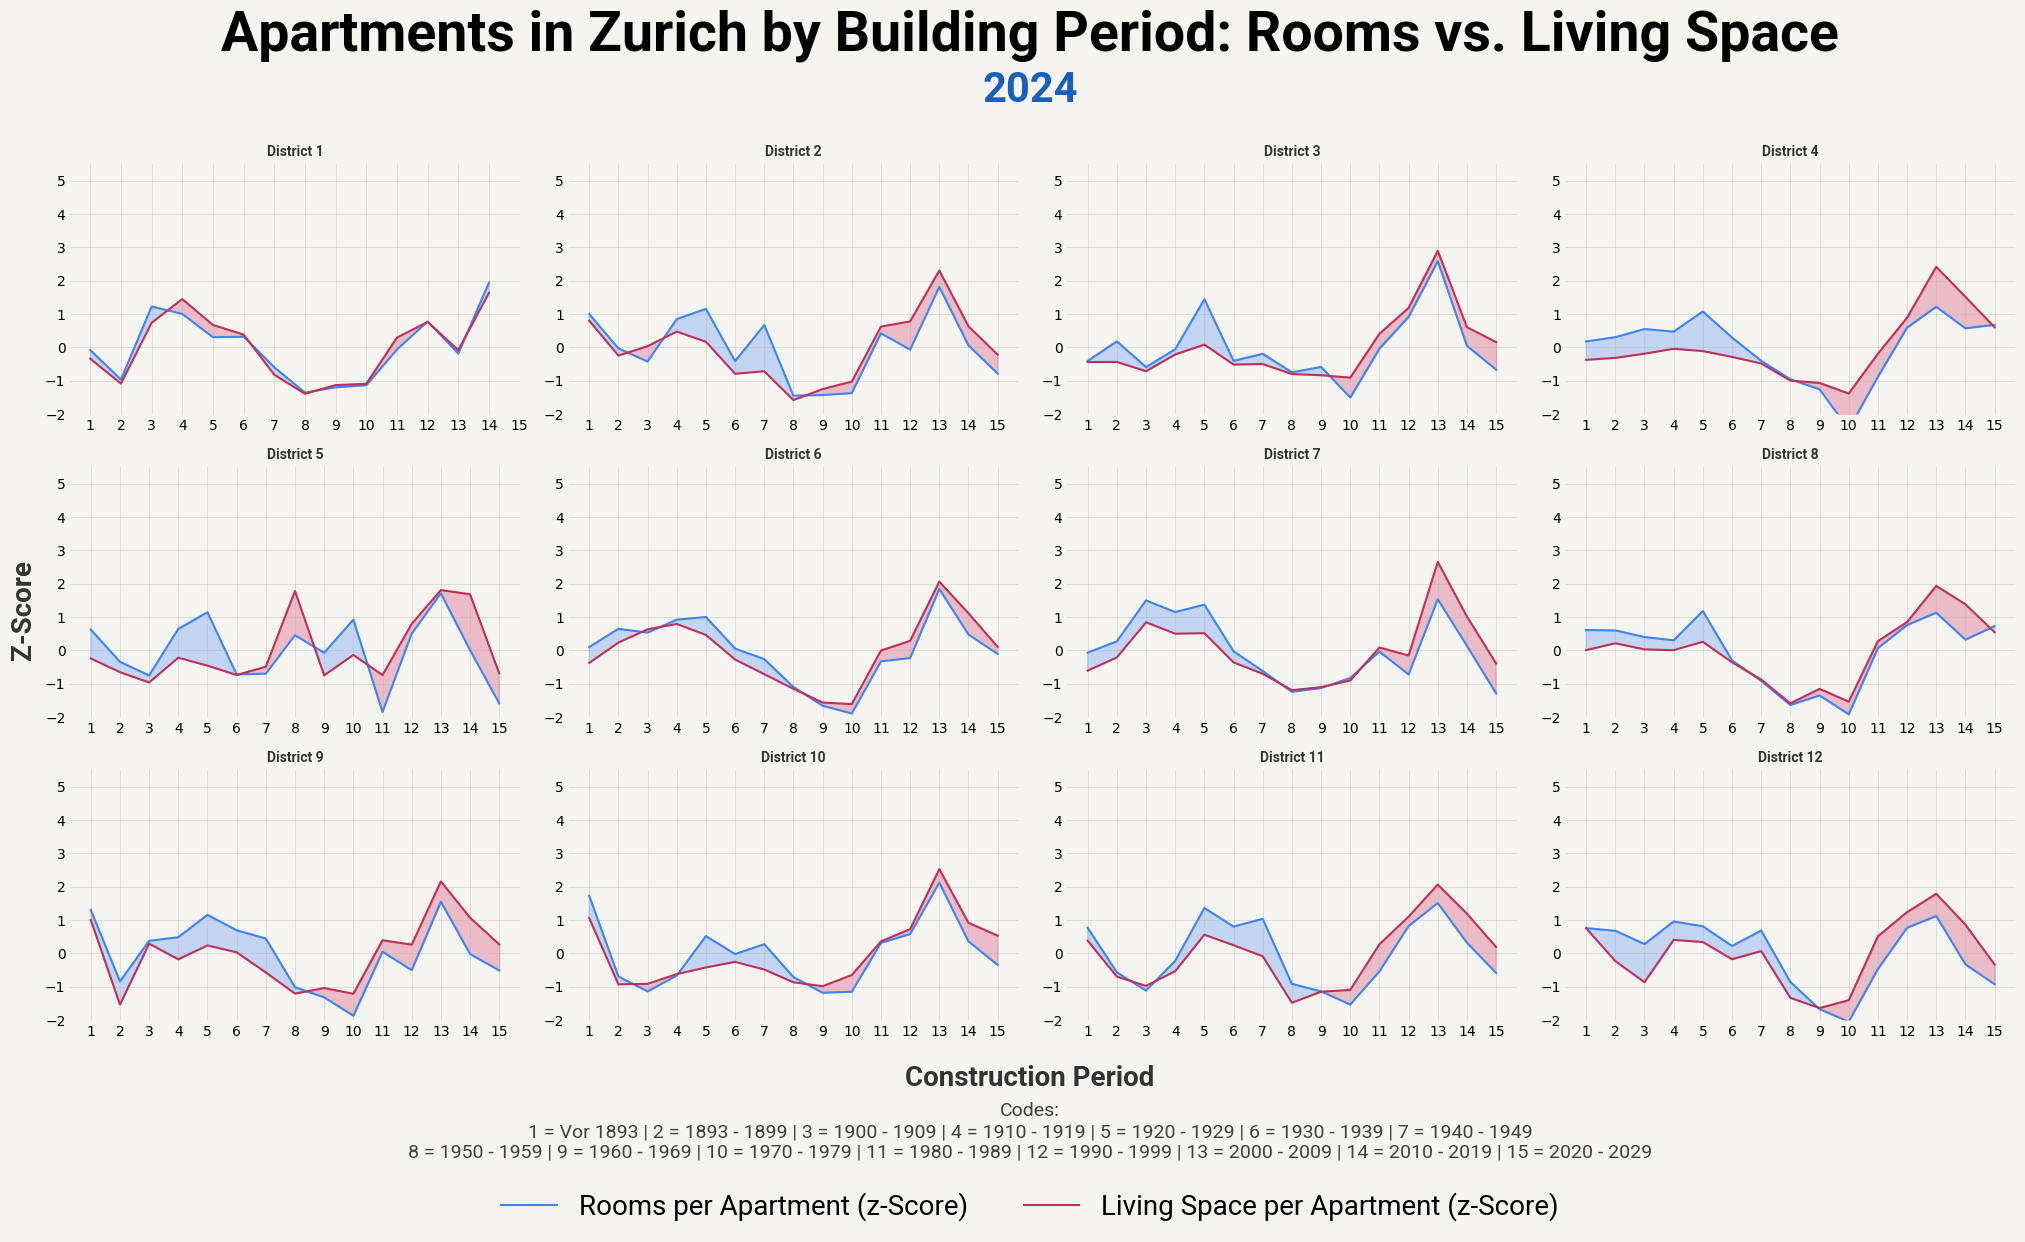

In [168]:
"""
This script visualises the apartment stocks of 2024, focusing on the period in which each apartment was built. For each district, two standardised indicators are plotted.
(1) the average number of rooms per apartment, and
(2) the average living area per apartment.
Both variables are expressed as z-scores to ensure comparability across periods and districts.

Each district is represented in its own subplot, resulting in a multi-panel figure that allows
a direct visual comparison of temporal trends across the city. The construction period is treated
as the temporal axis, encoded by discrete numerical categories. These categories are also mapped
to their descriptive labels at the bottom of the figure.

Shaded areas between the two curves highlight which variable dominates in a given period:
blue shading indicates that apartments had a disproportionately higher number of rooms,
while pink shading indicates that living area was relatively larger.

The figure is designed to emphasize cross-district differences while maintaining full visual
consistency across axes, scales, and layout.
"""

# A separate copy of the dataset is created to preserve the original object.
df_base = building_stock_building_period_2024.copy()

"""
Districts are sorted according to the numeric identifier contained in their name.
This yields a logically ordered sequence ("District 1", "District 2", ..., "District 12")
that corresponds to Zurich's official district numbering.
"""

df_base["district_name"] = (
    df_base["district_name"]
    .str.replace("Kreis", "District", regex=False)
)

districts_sorted = sorted(
    df_base["district_name"].unique(),
    key=lambda x: int(x.split()[-1])
)

"""
Construction-period codes are collected once for the entire city.
Using a globally consistent set of x-ticks ensures that all subplots share the same
temporal reference frame, which is essential for comparability.
"""
x_vals = np.sort(df_base["building_period_sort"].unique())

"""
A 3x4 grid of subplots is created, providing a dedicated panel for each district.
The figure size is chosen so that labels, titles, and line structures remain legible
despite the number of subplots.
"""
n_rows, n_cols = 3, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
axes = axes.flatten()

# Additional spacing between subplots improves visual separation of districts.
fig.subplots_adjust(hspace=0.35)

"""
Two invisible Line2D objects are created for the legend.
They serve as labeled color references for the z-score of rooms and living area,
ensuring consistent legend entries without duplicating elements inside the subplots.
"""
line_rooms = plt.Line2D([], [], color=BLUE, label="Rooms per Apartment (z-Score)")
line_area  = plt.Line2D([], [], color=PINK, label="Living Space per Apartment (z-Score)")

"""
The core visualization loop: each district is plotted in its own subplot.
For every district, the dataset is filtered, sorted chronologically, and then rendered
as a pair of line graphs. The shared approach across subplots preserves analytical coherence.
"""
for ax, district in zip(axes, districts_sorted):

    # Extract time-sorted observations for the district
    df_district = (
        df_base[df_base["district_name"] == district]
        .sort_values("building_period_sort")
    )

    """
    Each subplot shows two trajectories:
    - rooms_z: standardized number of rooms
    - area_z: standardized living space
    The use of z-scores ensures that differences in scale between variables do not distort
    the visual comparison.
    """
    x = df_district["building_period_sort"].values
    y_rooms = df_district["rooms_z"].values
    y_area  = df_district["area_z"].values

    # Line plots for both indicators
    ax.plot(x, y_rooms, color=BLUE)
    ax.plot(x, y_area,  color=PINK)

    """
    The filled area between curves highlights which indicator dominates in each time period.
    This technique supports visual interpretation by emphasizing the relative balance between
    room count and floor area. Blue shading signals higher room density, pink shading signals
    larger floor area.
    """
    ax.fill_between(
        x, y_rooms, y_area,
        where=(y_rooms > y_area),
        interpolate=True,
        color=BLUE_LIGHT,
        alpha=0.3,
    )

    ax.fill_between(
        x, y_rooms, y_area,
        where=(y_rooms <= y_area),
        interpolate=True,
        color=PINK_LIGHT,
        alpha=0.3,
    )

    # All subplots use a common set of construction-period ticks
    ax.set_xticks(x_vals)

    """
    A uniform y-axis range is imposed across all districts.
    """
    ax.set_ylim(-2, 5.5)

    # Visual styling: background, hidden spines, and lightweight gridlines
    ax.set_facecolor(BACKGROUND)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # A subtle grid supports reading values without overwhelming the plot
    ax.grid(which="both", lw=0.6, alpha=0.4)
    ax.tick_params(axis="both", length=0)

    # Each panel is labeled with the district it represents
    ax.set_title(district, font=bold_font, color=GREY20)

"""
If fewer districts exist than subplot slots, the remaining axes are hidden.
This avoids showing empty placeholders and keeps the figure aesthetically clean.
"""
for ax in axes[len(districts_sorted):]:
    ax.set_visible(False)

# Apply a shared background color to the entire figure
fig.set_facecolor(BACKGROUND)

"""
Global figure labels provide overarching context:
- A main title describing the subject of analysis,
- A year marker,
- A global y-axis label for z-scores,
- A global x-axis label for construction periods.
"""
fig.text(
    0.5, 0.95,
    "Apartments in Zurich by Building Period: Rooms vs. Living Space",
    ha="center", va="top",
    fontsize=40, fontweight="bold", font=bold_font, color=BLACK,
)

fig.text(
    0.5, 0.9,
    "2024",
    ha="center", va="top",
    fontsize=30, fontweight="bold", font=bold_font, 
    color=BLUE_DARK,
)

fig.text(
    -0.01, 0.45, "Z-Score",
    va="center", rotation="vertical",
    fontsize=20, fontweight="bold", font=bold_font, color=GREY20,
)

fig.text(
    0.5, 0.06, "Construction Period",
    ha="center", va="center",
    fontsize=20, fontweight="bold", font=bold_font, color=GREY20,
)

"""
To make the numerical construction-period codes interpretable,
a mapping table is created from the full dataset. The mapping is printed at the bottom
of the figure as a compact legend, split into two lines to save space.
"""
periods = (
    df_base[["building_period_sort", "building_period"]]
    .drop_duplicates()
    .sort_values("building_period_sort")
)

mapping_entries = [
    f"{int(row.building_period_sort)} = {row.building_period}"
    for _, row in periods.iterrows()
]

half = len(mapping_entries) // 2
line1 = " | ".join(mapping_entries[:half])
line2 = " | ".join(mapping_entries[half:])

fig.text(
    0.5, 0.015,
    f"Codes:\n{line1}\n{line2}",
    ha="center", va="center",
    fontsize=14,
    color=GREY25,
    font=regular_font,
)

"""
A centralized legend is placed beneath all subplots, representing the two z-score indicators.
This avoids redundancy within each subplot while preserving interpretability.
"""

regular_font_lines = regular_font.copy()
regular_font_lines.set_size(20)

fig.legend(
    handles=[line_rooms, line_area],
    loc="lower center",
    bbox_to_anchor=(0.5, -0.08), 
    ncol=2,
    frameon=False,
    fontsize=20,
    prop = regular_font_lines,
)

"""
The layout is tightened to ensure that subplots, legend, and titles fit together harmoniously
without overlapping. Margins are reserved explicitly for the title area and lower legend.
"""
plt.tight_layout(rect=[0, 0.08, 1, 0.85])

"""
The completed figure is exported as a high-resolution PNG. A high dpi value is chosen to ensure
that labels and lines remain crisp when included in academic reports or presentations.
"""
fig.savefig(
    "../Plots/Line.png",
    dpi=1000,
    bbox_inches="tight",
)


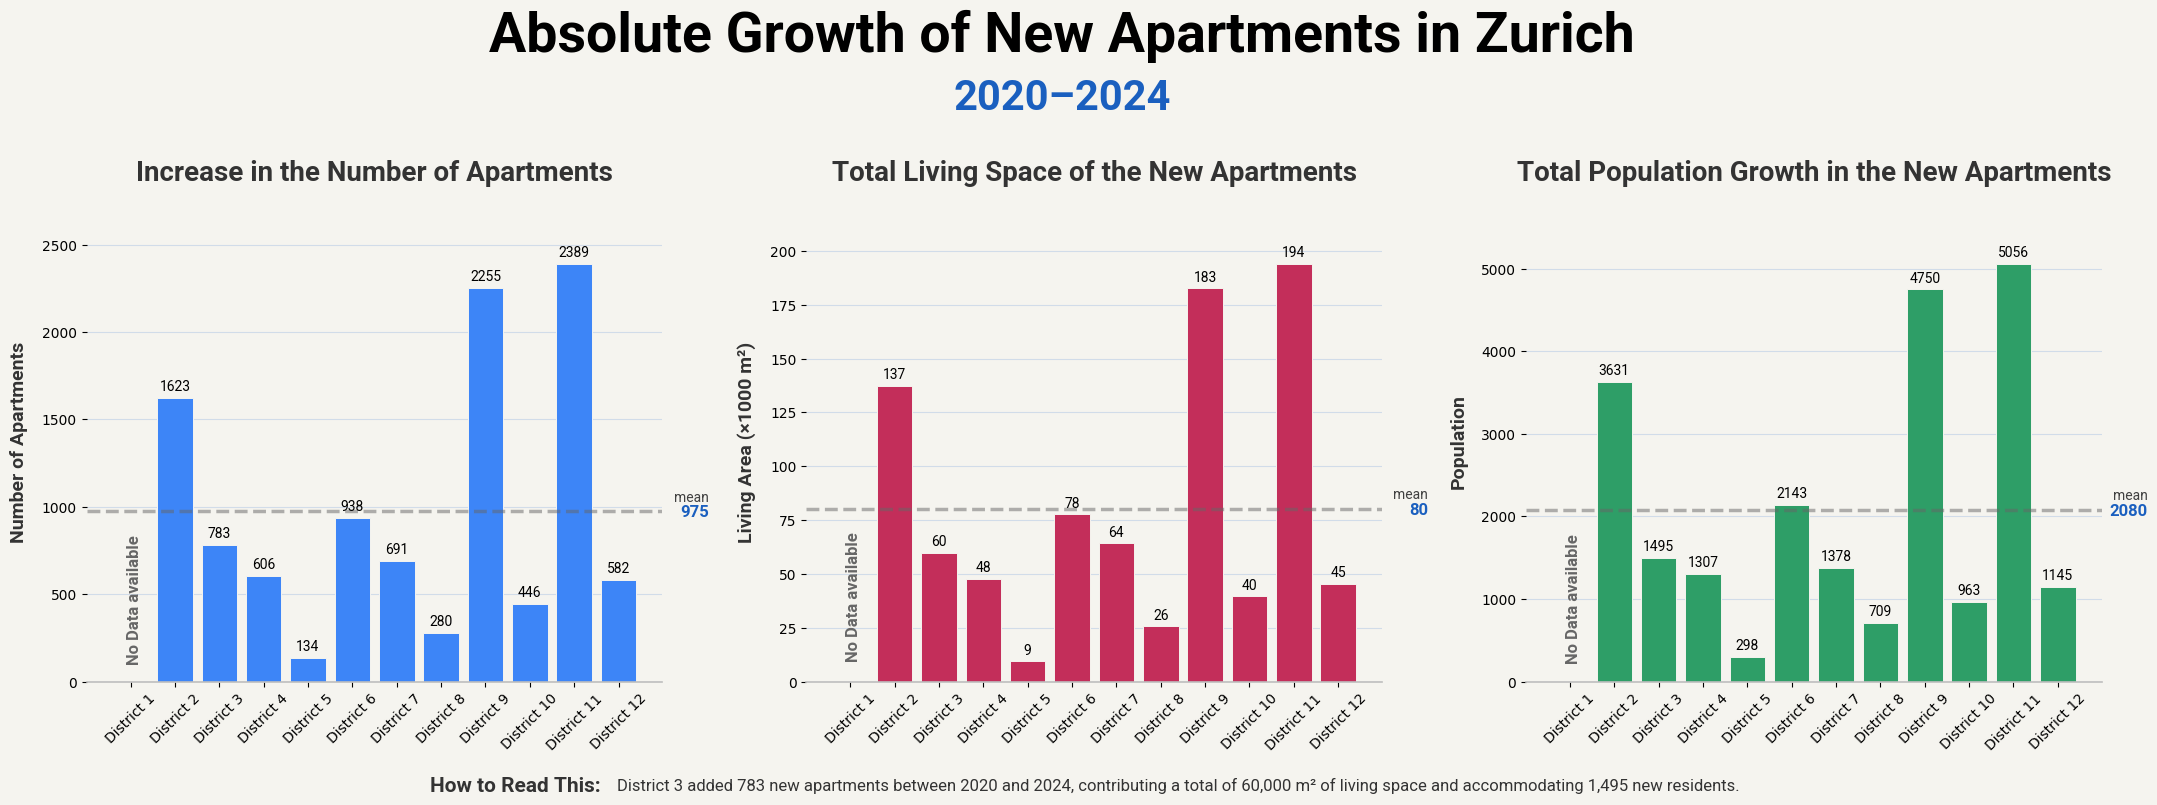

In [169]:
"""
This code visualizes the absolute growth of residential units in the city of Zurich
by district over a selected five-year period.

Three related indicators of urban growth are shown side by side:

1. Increase in the number of apartments,
2. Increase in total living area,
3. Increase in total population.

Each indicator is represented as a separate bar chart, sharing the same
x-axis (districts) but differing in scale and unit on the y-axis.
This layout enables a direct visual comparison of how different aspects
of urban growth are distributed spatially across Zurich's districts
within the chosen time window.
"""

# ---------------- Data preparation ----------------
period = "2020–2024"
df = building_expansion.copy()

"""
The dataset is restricted to a single five-year period. This focuses
the analysis on a specific phase of urban development and ensures that
all values plotted refer to the same temporal window.
"""
df = df[df["five_year_period"] == period]

"""
Only the variables needed for the visualization are retained:
- district_name: name of the district (e.g. "Kreis 1"),
- living_area: increase in total living area (e.g. in m²),
- num_apartments: increase in the number of apartments,
- population_total: increase in the total population.

Missing values are dropped to avoid plotting incomplete data.
"""
df = df[["district_name", "living_area", "num_apartments", "population_total"]].dropna().copy()

"""
A numerical district identifier is extracted from the district name.
This allows the districts to be sorted numerically (1, 2, 3, ...) rather than
alphabetically, which is more meaningful in the Zurich context.
"""
df["district_nr"] = df["district_name"].str.extract(r"(\d+)").astype(int)

"""
The German label "Kreis" is replaced with "District", so that x-axis labels
are more accessible to an English-speaking audience.
"""
df["district_name"] = df["district_name"].str.replace("Kreis", "District", regex=False)

"""
Districts are sorted by their numeric index to produce a coherent spatial
ordering in the bar charts, typically from District 1 to District 12.
"""
df = df.sort_values("district_nr")

# The x-axis categories (district names) are taken from the cleaned and sorted DataFrame.
x = df["district_name"]

# ---------------- Layout & color configuration ----------------
"""
Three indicators are visualized, each with its own color, title and y-axis label.
The lists below define these parallel configurations so that a single plotting loop
can generate all three panels in a consistent way.
"""
colors = [BLUE, PINK, GREEN]
cols   = ["num_apartments", "living_area", "population_total"]
titles = [
    "Increase in the Number of Apartments",
    "Total Living Space of the New Apartments",
    "Total Population Growth in the New Apartments",
]
ylabs  = [
    "Number of Apartments",
    "Living Area (×1000 m²)",
    "Population",
]

"""
A figure with three horizontally arranged subplots is created.
Each subplot corresponds to one of the growth indicators listed above.
The overall figure title summarizes the content and the chosen spatial scope.
"""
fig, axes = plt.subplots(1, 3, figsize=(26, 8))
fig.patch.set_facecolor(BACKGROUND)
fig.suptitle(
    "Absolute Growth of New Apartments in Zurich",
    fontsize=40,
    y=1.09,
    color="black",
    font = bold_font,
)

"""
The selected five-year period is displayed near the top of the figure
as a secondary title, reinforcing the temporal frame of reference
for the analysis.
"""
fig.text(
    0.5, 0.98,
    period,
    ha='center',
    va='center',
    fontsize=30,
    font = bold_font,
    color=BLUE_DARK,
)

# ---------------- Plot loop ----------------
"""
Each axis in `axes` is paired with:
- one growth variable (col),
- one color,
- one subplot title, and
- one y-axis label.

This loop constructs three bar charts with a shared x-axis (districts) but
indicator-specific y-axes. Living area is rescaled to thousands of m²
for more readable axis values.
"""
for ax, col, c, title, ylab in zip(axes, cols, colors, titles, ylabs):
    # Extract the data series for the current indicator
    y = df[col].to_numpy()

    """
    Living area values are expressed in units of 1000 m² for the plot.
    This keeps axis tick labels compact and easier to read, especially
    when values are large.
    """
    if col == "living_area":
        y = y / 1000  # convert to thousands of m²

    # --- compute mean for the line ---
    mean_val = y.mean()

    # Create the bar chart
    ax.bar("District 1", 0, color="gray")  
    bars = ax.bar(x, y, color=c, edgecolor=BACKGROUND, linewidth=0.7)

    # --- add mean line ---
    ax.axhline(mean_val, color=GREY40, linestyle="--", linewidth=2.5, alpha=0.5)

    ax.text(
    1.08, mean_val - (0.021 * ax.get_ylim()[1]),  
    f"mean\n", 
    color=GREY25,
    font=regular_font, 
    fontsize=10, 
    va="bottom", 
    ha="right",
    transform=ax.get_yaxis_transform()  # text stays in axis coords
)
    ax.text(
        1.08, mean_val - (0.02 * ax.get_ylim()[1]),  
        f"{mean_val:.0f}", 
        color=BLUE_DARK,
        font=bold_font, 
        fontsize=12, 
        va="bottom", 
        ha="right",
        transform=ax.get_yaxis_transform()  # text stays in axis coords
    )

    ax.text(
        0.08, mean_val - (0.35 * ax.get_ylim()[1]),  
        "No Data available", 
        color=GREY40,
        font=bold_font, 
        fontsize=12, 
        va="bottom", 
        ha="center",
        rotation=90
    )

    """
    Each subplot receives a descriptive title and an indicator-specific y-axis label.
    District names are rotated on the x-axis to reduce overlap and improve legibility.
    The y-axis limit is set slightly above the maximum observed value to give
    the bar tops visual breathing space.
    """
    ax.set_title(title, font = bold_font, fontsize=20, pad=15, color=GREY20)
    ax.set_ylabel(ylab, fontsize=14, font=bold_font, labelpad=10, color=GREY20)
    ax.tick_params(axis="x", rotation=45,)
    ax.set_ylim(0, y.max() * 1.15)

    """
    Subplot styling:
    - The background color is aligned with the overall theme.
    - A horizontal grid on the y-axis is drawn behind the bars
      to aid in reading values without overpowering the visual.
    - Most spines are removed to create a cleaner, more modern look,
      with only the bottom spine retained and slightly emphasized.
    """
    ax.set_facecolor(BACKGROUND)
    ax.set_axisbelow(True)              # draw grid lines behind the bars
    ax.grid(axis="y", color="#C9D7E8", linewidth=0.8, alpha=0.8)

    for spine in ("top", "left", "right"):
        ax.spines[spine].set_visible(False)
    ax.spines["bottom"].set_color("#BEBEBE")
    ax.spines["bottom"].set_linewidth(1.2)

    """
    Each bar is annotated with its numerical value. This turns the bars into
    explicit labels rather than approximate indicators, which is useful
    when the exact magnitude of growth per district is of analytical interest.
    """
    ax.bar_label(bars, fmt="%.0f", padding=3, fontsize=10, font = regular_font)

fig.text(
    0.545, 0.12,
    "District 3 added 783 new apartments between 2020 and 2024, contributing a total of 60,000 m² of living space and accommodating 1,495 new residents.",
    ha="center",
    va="center",
    fontsize=12,
    font=regular_font,
    color=GREY20
)

fig.text(
    0.29, 0.12,
    "How to Read This:" ,  
    ha="center",
    va="center",
    fontsize=15,
    font=bold_font,
    color=GREY20
)


"""
The horizontal spacing between subplots is slightly increased, and room is reserved
at the top and bottom for titles and rotated x-axis labels.
"""
plt.subplots_adjust(wspace=0.25, top=0.85, bottom=0.25)
fig.savefig("../Plots/Bar_abs.png", dpi=300, bbox_inches="tight")
plt.show()


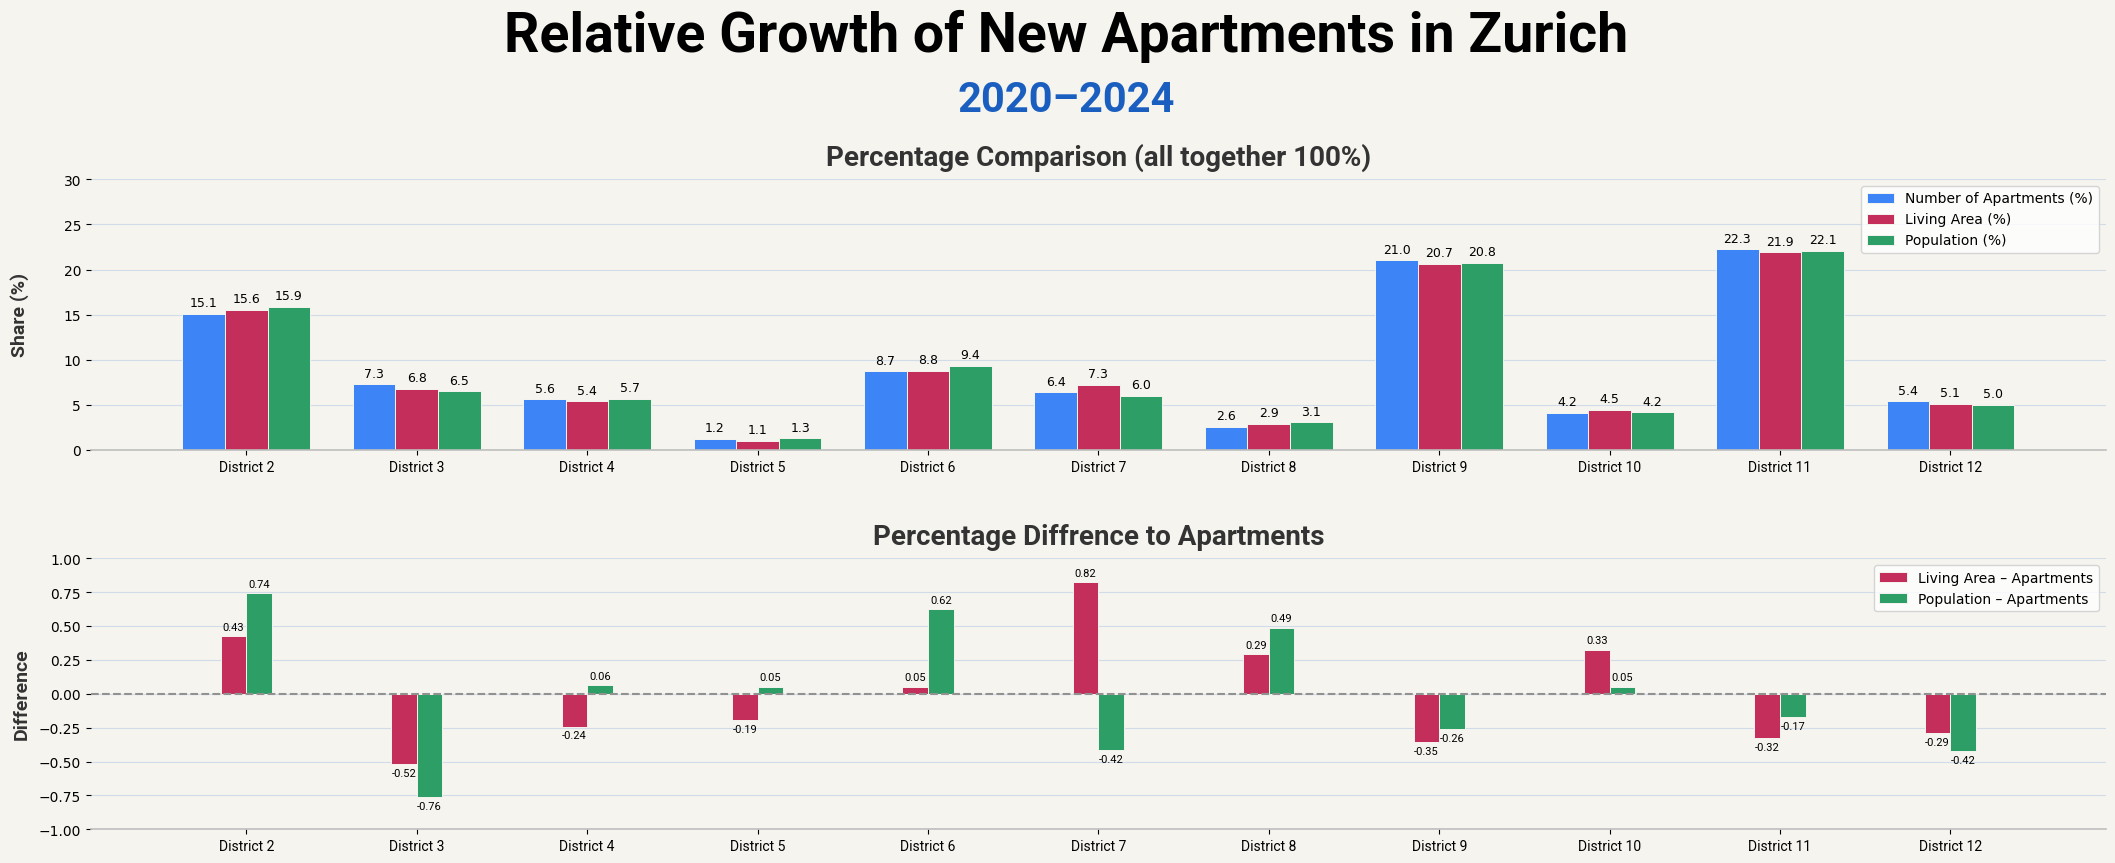

In [170]:
"""
This code examines the *relative* contribution of each Zurich district to the
overall growth of three key indicators over a five-year period:

1. Living area (in thousand square meters),
2. Number of apartments,
3. Population.

The analysis is split into two stacked bar charts:

- The upper panel displays, for each district, the percentage share of total growth
  in each indicator. This highlights whether a district contributes more or less
  than others to each dimension of growth.

- The lower panel shows, for each district, how the percentage shares of living area
  and population deviate from the percentage share of apartments. These differences
  are expressed in percentage points and provide a more nuanced view of whether
  a district's growth pattern is biased towards larger dwellings, more residents,
  or simply more units.
"""

# Create numerical x-positions for each district to be used as bar positions.
x_pos = np.arange(len(x))
bold_font_subtitle = bold_font.copy()
bold_font_subtitle.set_size(20)

bold_font_label = bold_font.copy()
bold_font_label.set_size(14)
"""
Absolute values are extracted for each indicator:

- living_abs: total growth in living area in each district,
  converted to thousands of square meters (to keep the magnitude manageable).
- dwellings_abs: total growth in the number of apartments.
- pop_abs: total growth in population.

These serve as the basis for computing each district’s relative contribution.
"""
living_abs    = df["living_area"] / 1000    # expressed in units of 1000 m²
dwellings_abs = df["num_apartments"]
pop_abs       = df["population_total"]

"""
For each indicator, the share of a district in the overall city-wide growth
is computed as a percentage. The resulting values can be interpreted as:

- y_living_pct: share of city-wide increase in living area,
- y_dwell_pct: share of city-wide increase in number of apartments,
- y_pop_pct: share of city-wide increase in population.

These metrics are the foundation for the upper plot.
"""
y_living_pct = living_abs    / living_abs.sum()    * 100
y_dwell_pct  = dwellings_abs / dwellings_abs.sum() * 100
y_pop_pct    = pop_abs       / pop_abs.sum()       * 100

"""
The visualization consists of two vertically stacked subplots sharing the same
x-axis (districts). The height ratios are equal, so both panels occupy roughly
the same vertical space. The shared x-axis helps visually connect percentage
shares and percentage-point deviations for each district.
"""
fig, (ax_pct, ax_diff) = plt.subplots(
    2, 1,
    figsize=(26, 10),
    sharex=True,
    gridspec_kw={"height_ratios": [1, 1], "hspace": 0.4}
)
fig.patch.set_facecolor(BACKGROUND)
fig.suptitle(
    f"Relative Growth of New Apartments in Zurich",
    color=BLACK,
    fontsize=40,
    font = bold_font,
    y=1.07,
)

fig.text(
    0.5, 0.98,
    period,
    ha='center',
    va='center',
    fontsize=30,
    font = bold_font,
    color=BLUE_DARK,
)

# ---------------- Upper plot: percentage shares ----------------
"""
The upper plot compares, for each district, the percentage shares of total growth
in apartments, living area, and population. The bars are placed side by side
around each district position to enable direct comparison.

A common bar width is chosen and small horizontal offsets are used to arrange
the three bars (one per indicator) for each district.
"""
w = 0.25

bars_y2 = ax_pct.bar(
    x_pos - w,
    y_dwell_pct,
    w,
    color=BLUE,
    edgecolor=BACKGROUND,
    linewidth=0.7,
    label="Number of Apartments (%)",
)
bars_y1 = ax_pct.bar(
    x_pos,
    y_living_pct,
    w,
    color=PINK,
    edgecolor=BACKGROUND,
    linewidth=0.7,
    label="Living Area (%)",
)
bars_y3 = ax_pct.bar(
    x_pos + w,
    y_pop_pct,
    w,
    color=GREEN,
    edgecolor=BACKGROUND,
    linewidth=0.7,
    label="Population (%)",
)

"""
The title and y-axis label of the upper panel introduce the interpretation
of the values as percentage shares. District names are plotted along the x-axis,
rotated slightly for better readability. The y-axis limit is capped at 30%
to focus on the relevant range of variation.
"""
ax_pct.set_title(
    "Percentage Comparison (all together 100%)",
    pad=10,
    fontproperties = bold_font_subtitle,
    color = GREY20
)
ax_pct.set_ylabel("Share (%)", labelpad=25 , fontproperties = bold_font_label, fontsize=14, color=GREY20)
ax_pct.set_xticks(x_pos)
ax_pct.set_xticklabels(x, ha="center", fontproperties = regular_font)


ax_pct.set_ylim(0, 30)

"""
Stylistically, the upper panel adopts the same visual language as the other
figures in the project: a light background, subtle horizontal gridlines,
and minimal use of axis spines. A legend is placed in the upper right corner,
distinguishing the three indicators via color coding.
"""
ax_pct.set_facecolor(BACKGROUND)
ax_pct.set_axisbelow(True)
ax_pct.grid(axis="y", color="#C9D7E8", linewidth=0.8, alpha=0.8)

for spine in ("top", "left", "right"):
    ax_pct.spines[spine].set_visible(False)
ax_pct.spines["bottom"].set_color("#BEBEBE")
ax_pct.spines["bottom"].set_linewidth(1.2)

ax_pct.legend(loc="upper right", frameon=True, facecolor="white")

"""
Each bar in the upper panel is annotated with its corresponding percentage value.
This annotation transforms the chart from a purely visual comparison into a
quantitatively precise representation.
"""
ax_pct.bar_label(bars_y2, padding=3, fmt="%.1f", fontsize=9)
ax_pct.bar_label(bars_y1, padding=3, fmt="%.1f", fontsize=9)
ax_pct.bar_label(bars_y3, padding=3, fmt="%.1f", fontsize=9)

# ---------------- Lower plot: deviations in percentage points ----------------
"""
The lower plot shifts the focus from absolute percentage shares to relative
differences between indicators. Specifically, it shows how the shares of living
area and population deviate from the share of apartments in each district.

Positive values indicate that the respective indicator has a higher share
than the apartment count in that district; negative values indicate the opposite.
"""
diff_living = y_living_pct - y_dwell_pct
diff_pop    = y_pop_pct    - y_dwell_pct

"""
A smaller bar width is chosen for the deviation chart, and the bars for living
area and population are placed on either side of the central district position.
This symmetric arrangement emphasizes that both are deviations from the same
reference (apartments).
"""
w2 = 0.15
bars_diff_liv = ax_diff.bar(
    x_pos - w2 / 2,
    diff_living,
    w2,
    color=PINK,
    edgecolor=BACKGROUND,
    linewidth=0.7,
    label="Living Area – Apartments",
)
bars_diff_pop = ax_diff.bar(
    x_pos + w2 / 2,
    diff_pop,
    w2,
    color=GREEN,
    edgecolor=BACKGROUND,
    linewidth=0.7,
    label="Population – Apartments",
)

"""
The lower panel explicitly refers to deviations "in percentage points"
to distinguish them from the shares shown above. The y-axis is tightly
bounded between -1 and +1 percentage points, which highlights even small
deviations from the apartment-based share.
"""
ax_diff.set_title(
    "Percentage Diffrence to Apartments",
    pad=10,
    fontsize=30,
    fontproperties = bold_font_subtitle,
    color = GREY20)

ax_diff.set_ylabel("Difference", labelpad=6, fontproperties = bold_font_label, fontsize=14, color=GREY20)
ax_diff.set_xticks(x_pos)
ax_diff.set_xticklabels(x, ha="center", fontproperties = regular_font)

ax_diff.set_ylim(-1, 1)

"""
A horizontal dashed line at zero serves as a visual baseline:
bars above this line represent districts where the respective indicator
has a higher relative share than apartments; bars below it indicate
a lower relative share.
"""
ax_diff.axhline(0, color="#919191", linewidth=1.5, linestyle="--")

"""
The styling of the lower panel mirrors that of the upper one to maintain
a coherent visual identity. A separate legend identifies which bars correspond
to living area and which to population deviations.
"""
ax_diff.set_facecolor(BACKGROUND)
ax_diff.set_axisbelow(True)
ax_diff.grid(axis="y", color="#C9D7E8", linewidth=0.8, alpha=0.8)

for spine in ("top", "left", "right"):
    ax_diff.spines[spine].set_visible(False)
ax_diff.spines["bottom"].set_color("#BEBEBE")
ax_diff.spines["bottom"].set_linewidth(1.2)

ax_diff.legend(loc="upper right", frameon=True, facecolor="white")

"""
Each deviation bar is also labeled numerically, using two decimal places.
Because deviations are typically small, this higher precision is useful
for analytical interpretation.
"""
ax_diff.bar_label(bars_diff_liv, padding=3, fmt="%.2f", fontsize=8, fontproperties = regular_font)
ax_diff.bar_label(bars_diff_pop, padding=3, fmt="%.2f", fontsize=8, fontproperties = regular_font)

"""
A final layout adjustment ensures that the title, axis labels, and rotated
x-axis tick labels do not overlap and that the two panels are visually balanced
within the figure.
"""
ax_pct.tick_params(axis="x", which="both", labelbottom=True)
plt.subplots_adjust(top=0.9, bottom=0.25)
plt.setp(ax_pct.get_xticklabels(), visible=True)
"""
A moderate dpi value is chosen, which is usually sufficient for
screen and standard print use cases.
"""
fig.savefig("../Plots/Bar_rel.png", dpi=300, bbox_inches="tight")
plt.show()


c:\Users\livio\Documents\FHNW\gdv\venv_gdv\Lib\site-packages\pywaffle\waffle.py:283: PendingDeprecationWarning: The set_tight_layout function will be deprecated in a future version. Use set_layout_engine instead.
  self.set_tight_layout(self.fig_args["tight"])
C:\Users\livio\AppData\Local\Temp\ipykernel_15248\569499762.py:136: PendingDeprecationWarning: The set_tight_layout function will be deprecated in a future version. Use set_layout_engine instead.
  fig.set_tight_layout(False)
C:\Users\livio\AppData\Local\Temp\ipykernel_15248\569499762.py:221: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
C:\Users\livio\AppData\Local\Temp\ipykernel_15248\569499762.py:221: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().

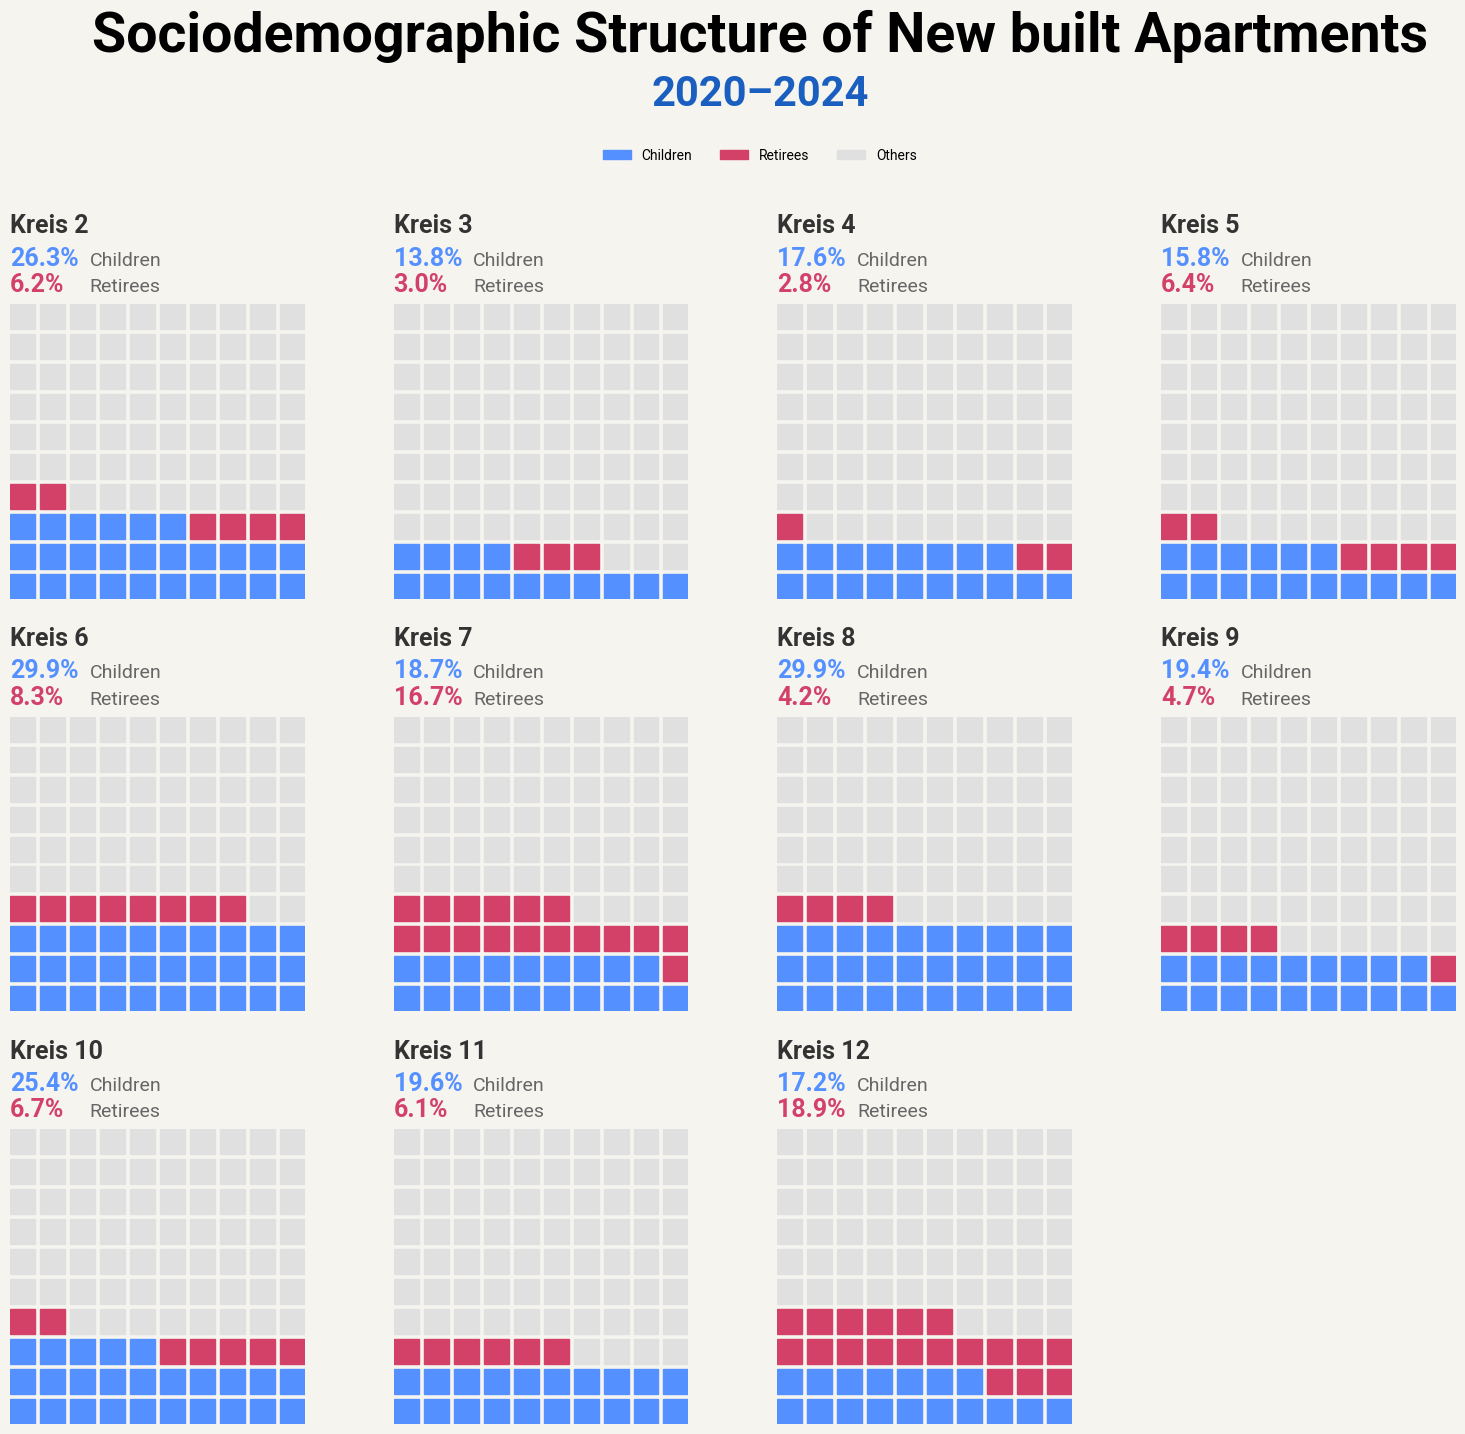

In [171]:
"""
This code visualizes the population structure in Zurich’s districts using
waffle charts for a specified 5 year period. For each district, the total population
is broken down into three groups:

1. Children
2. Retirees
3. Others (remaining population)

Each district is represented by a small waffle chart, where the proportion of
colored squares corresponds to the relative size of these groups within the
district’s total population.

The figure is arranged as a grid of district panels, complemented by a global
title and a legend. For each district, summary statistics (percentages of
children and retirees) are displayed above the corresponding waffle chart.

The visualization is designed to highlight spatial variation in demographic
structure across districts within the same time period.
"""

# A fresh copy of the expansion dataset is created to avoid modifying the original.
df = building_expansion.copy()
period_of_interest = "2020–2024"

"""
The counts of children and retirees are cleaned by replacing missing values (NaN)
with zeros. This ensures that districts without recorded values for these groups
are treated as having zero members in that category, rather than being dropped
from the analysis.
"""
df["num_children"] = df["num_children"].fillna(0)
df["num_retirees"] = df["num_retirees"].fillna(0)

"""
The "other" population group is defined as the residual between the total population
and the sum of children and retirees. A lower bound of zero is enforced to avoid
negative counts, which could arise from inconsistencies or rounding issues in the data.
"""
df["other"] = (
    df["population_total"]
    - df["num_children"]
    - df["num_retirees"]
).clip(lower=0)

"""
Each district is assigned a numeric identifier extracted from its name (e.g. "Kreis 1"
→ 1). This numeric key facilitates sorting the districts in a logical order that
corresponds to Zurich’s standard district numbering.
"""
df["kreis_num"] = (
    df["district_name"]
    .str.extract(r"(\d+)", expand=False)
    .astype(int)
)

"""
The DataFrame is sorted by this numeric district identifier, ensuring that
districts appear in a consistent spatial order across the figure.
"""
df = df.sort_values("kreis_num")

# The ordered list of district names is extracted and used to structure the waffle layout.
districts = df["district_name"].unique()

"""
The three demographic groups are encoded with distinct colors:

- BLUE_LIGHT: Children
- PINK_LIGHT: Retirees
- "#E0E0E0": Others (remaining population)

These colors are reused consistently in both the waffle charts and the legend.
"""
colors_waffle = [BLUE_LIGHT, PINK_LIGHT, "#E0E0E0"]

"""
The `plots` dictionary stores the configuration entries for each district’s waffle chart.
Each entry contains the counts for children, retirees, and others for that district.
The `plot_index` keeps track of the panel index in the grid specification.
"""
plots = {}
plot_index = 1
n = len(districts)

"""
The number of columns in the subplot grid is fixed at four. The number of rows
is computed by rounding up the integer division of the number of districts by
the number of columns. This ensures that all districts fit into the grid.
"""
ncols = 4
nrows = math.ceil(n / ncols)

"""
A loop over all districts constructs the data for each waffle panel.
For each district, a dictionary of absolute counts for the three groups is created.
Districts with a total population of zero (sum of groups equals zero) are skipped,
as a waffle chart with no tiles would not be informative.
"""
for district in districts:
    row = df[df["district_name"] == district].iloc[0]
    values = {
        "Children": int(row["num_children"]),
        "Retirees": int(row["num_retirees"]),
        "Others": int(row["other"]),
    }
    if sum(values.values()) == 0:
        continue

    # Each district’s values are stored under a subplot specification key.
    plots[(nrows, ncols, plot_index)] = {"values": values}
    plot_index += 1

"""
The waffle chart figure is created using the `Waffle` class. Each subplot is
configured based on the `plots` dictionary. The number of rows and columns
inside each waffle (here 10x10) determines the resolution of the tile grid,
i.e., how finely the population is discretized into squares.

Tiles are filled vertically from a starting position in the southwest corner
("SW"), resulting in a fully tiled 10x10 grid per district.
"""
fig = plt.figure(
    FigureClass=Waffle,
    plots=plots,
    rows=10,
    columns=10,
    colors=colors_waffle,
    vertical=True,
    starting_location="SW",
    figsize=(15, 14),
)

# The figure background is aligned with the overall theme.
fig.patch.set_facecolor(BACKGROUND)
fig.set_tight_layout(False)

"""
The subplot layout is adjusted to leave space for the global title, period label,
and legend at the top, while also maintaining adequate separation between the
individual waffle panels.
"""
fig.subplots_adjust(
    left=0,
    right=1,
    bottom=0.1,
    top=0.9,
    wspace=0.1,
    hspace=0.4,
)

"""
A global title communicates the main theme of the visualization:
population structure by district. The specific period of interest,
such as 2020–2024, is displayed beneath the title as an additional
temporal qualifier.
"""
fig.suptitle(
    f"Sociodemographic Structure of New built Apartments",
    fontproperties=bold_font,
    fontsize=40,
    color=BLACK,
    y=1.11,
)

fig.text(
    0.5, 1.05,
    f"{period_of_interest}",
    ha="center",
    va="center",
    fontsize=30,
    fontproperties=bold_font,
    color=BLUE_DARK,
)

"""
A custom legend is constructed using patches that match the waffle colors.
The legend is placed centrally above the grid of waffle charts, describing
which color corresponds to children, retirees, and other population.
"""
legend_handles = [
    Patch(color=colors_waffle[0], label="Children"),
    Patch(color=colors_waffle[1], label="Retirees"),
    Patch(color=colors_waffle[2], label="Others"),
]

fig.legend(
    handles=legend_handles,
    loc="upper center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, 1.02),
    prop=regular_font,
    fontsize=18,
)

"""
Each Waffle subplot is then annotated individually. For every axis corresponding
to a district, the district name and summary percentages for children and retirees
are placed above the waffle chart. These annotations combine categorical
and quantitative information in a compact header.
"""
for i, ax in enumerate(fig.axes):
    if i >= len(districts):
        break

    district_name = districts[i]
    row = df[df["district_name"] == district_name].iloc[0]
    total = row["population_total"]

    """
    The shares of children and retirees are expressed as percentages of the
    total district population. If the total population is zero, the percentage
    is defined as zero to avoid division by zero.
    """
    pct_kids = (row["num_children"] / total * 100) if total > 0 else 0
    pct_ret  = (row["num_retirees"] / total * 100) if total > 0 else 0

    # Waffle automatically creates legends per subplot; these are removed
    # to avoid repetition and clutter, as a single global legend is used instead.
    ax.legend().remove()

    """
    The district name is written above the waffle in bold, followed by two
    lines indicating the percentages of children and retirees, each colored to
    match their waffle tiles. Descriptive text labels ("Children", "Retirees")
    accompany the percentages to clarify their meaning.
    """
    ax.text(
        x=0.0, y=1.24,
        s=district_name,
        fontproperties=bold_font,
        fontsize=18,
        color=GREY20,
        ha="left",
        transform=ax.transAxes,
    )

    ax.text(
        x=0.0, y=1.13,
        s=f"{pct_kids:.1f}%",
        fontproperties=bold_font,
        fontsize=18,
        color=BLUE_LIGHT,
        ha="left",
        transform=ax.transAxes,
    )
    ax.text(
        x=0.27, y=1.13,
        s="Children",
        fontproperties=regular_font,
        fontsize=14,
        color="#666666",
        ha="left",
        transform=ax.transAxes,
    )

    ax.text(
        x=0.0, y=1.04,
        s=f"{pct_ret:.1f}%",
        fontproperties=bold_font,
        fontsize=18,
        color=PINK_LIGHT,
        ha="left",
        transform=ax.transAxes,
    )
    ax.text(
        x=0.27, y=1.04,
        s="Retirees",
        fontproperties=regular_font,
        fontsize=14,
        color="#666666",
        ha="left",
        transform=ax.transAxes,
    )

"""
Finally, the entire figure is saved as a high-resolution PNG file.
The tight bounding box option ensures that the exported image
includes the entire layout (title, legend, and annotations)
without excessive white margins.
"""
fig.savefig(
    "../Plots/Waffle.png",
    dpi=1000,
    bbox_inches="tight",
)

plt.show()


C:\Users\livio\AppData\Local\Temp\ipykernel_15248\2706451981.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_kreise = cm.get_cmap("tab20", len(unique_kreise))


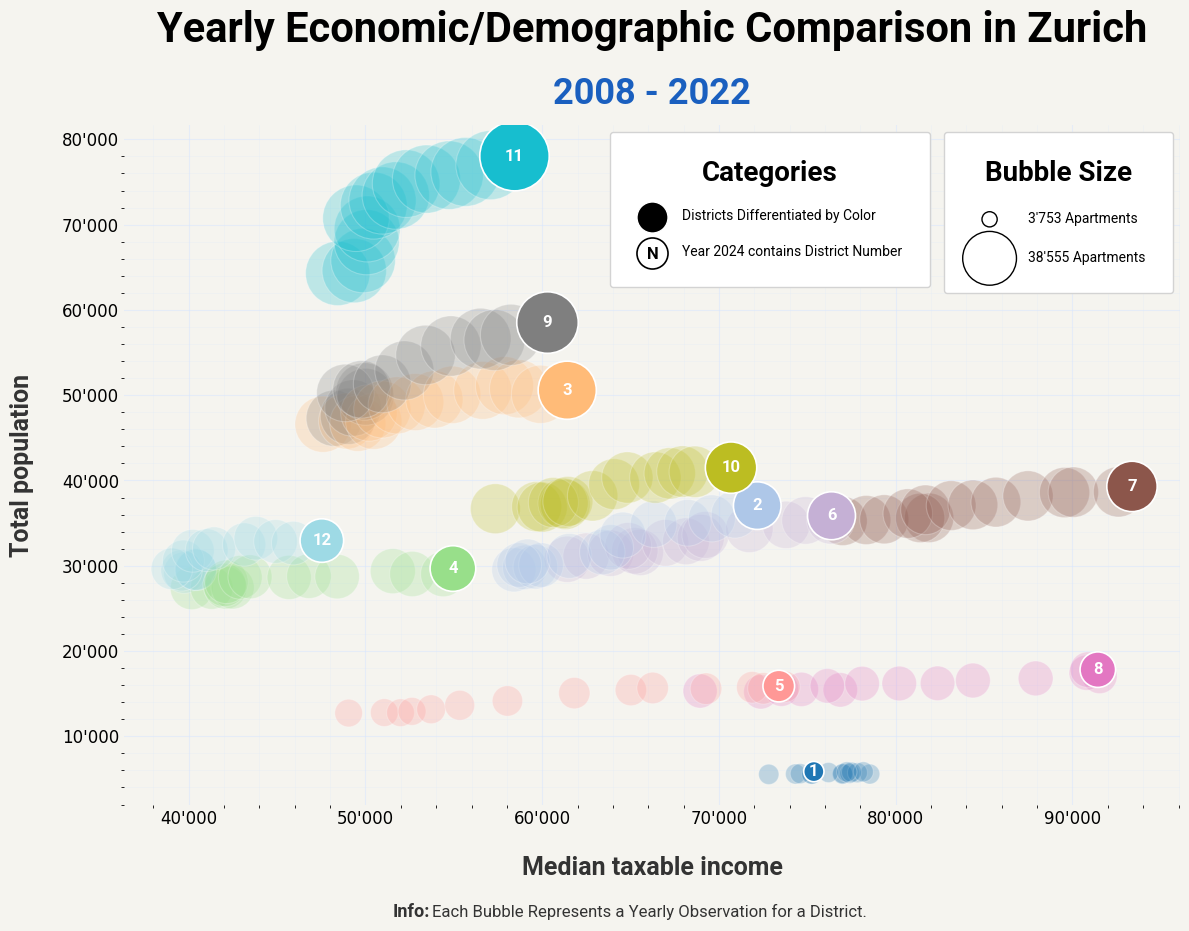

In [172]:
"""
This script visualizes the relationship between median taxable income and total population
for Zurich districts using a bubble chart. Each observation corresponds to a district-year
combination and is represented as a bubble in a two-dimensional space:

- x-axis: median taxable income
- y-axis: total population
- bubble size: number of apartments (proxy for housing stock or density)
- bubble color: district identity (constant across years for the same district)

To emphasize temporal development, all available years for each district are included,
but only the *latest* year per district is highlighted with fully opaque bubbles and
district labels. Older observations for each district are shown using the same color
but with increased transparency, creating a visual trajectory of the district's
position over time.

This design allows for the simultaneous exploration of:
1. Cross-sectional differences between districts (income, population, housing size),
2. Temporal changes in these characteristics,
3. The interplay between income levels and demographic scale across districts.
"""

# ---------------- Data preparation ----------------
"""
A copy of the original dataset is created to avoid modifying it in place.
"""
df = building_income_population.copy()
df["year"] = df["year"].astype(int)

"""
The core variables used in the bubble chart are extracted:

- x_data: median taxable income per district-year observation,
- y_data: total population per district-year observation,
- size_data: number of apartments, which determines bubble size,
- kreis_data: numeric district sorting key (used to group and color-code districts).

These Series form the basis of the visual encodings in the plot.
"""
x_data      = df["median_taxable_income"]
y_data      = df["population_total"]
size_data   = df["num_apartments"].astype(float)
kreis_data  = df["district_sort"]


# ---------------- Layout & colors ----------------
"""
A single figure and axis are created for the bubble chart.
The background color of both the figure and the axis is set to a project-wide
theme color defined as BACKGROUND.
"""
fig, ax = plt.subplots(figsize=(12, 9))
fig.set_facecolor(BACKGROUND)
ax.set_facecolor(BACKGROUND)


# ---------------- Bubble size mapping ----------------
"""
Bubble sizes are derived from the number of apartments in each observation.
To make the size differences visually meaningful, a linear scaling is applied
between a minimum and maximum marker size.

Special handling is included for cases where:
- all size_data values are identical (or effectively identical),
- or only a single unique value exists.

In such cases, all bubbles are assigned the same size to avoid division by zero
and to keep the visual representation stable.
"""
s_min = size_data.min()
s_max = size_data.max()

if size_data.nunique() <= 1 or s_max == s_min:
    # All bubbles share a uniform size if no variation exists
    sizes = np.full_like(size_data, 800.0)
else:
    # Linear scaling from a base size (200) to a maximum size (2500)
    sizes = 200 + (size_data - s_min) / (s_max - s_min) * (2500 - 200)

# ---------------- Color mapping by district ----------------
"""
Each district is assigned a distinct color, which is kept constant across years.
The 'tab20' colormap is used to generate a palette with one color per district.

The mapping is done via an integer encoding of district_sort:
    district_sort → index → colormap color

This allows bubbles belonging to the same district to be visually grouped, even
when multiple years are shown.
"""
unique_kreise = sorted(kreis_data.unique())
kreis_to_int = {k: i for i, k in enumerate(unique_kreise)}
cmap_kreise = cm.get_cmap("tab20", len(unique_kreise))
colors_by_kreis = kreis_data.map(kreis_to_int)

# ---------------- Identify latest year per district ----------------
"""
For each district, the latest year available in the dataset is identified.
A boolean mask 'is_latest' marks rows corresponding to these most recent
observations.

These will be emphasized in the visualization (opaque bubbles and labels),
while older years remain as semi-transparent background context.
"""
is_latest = df.groupby("district_sort")["year"].transform(
    lambda s: s == s.max()
)

# ---------------- Scatter plot: older years ----------------
"""
Older observations (non-latest year per district) are plotted first with
semi-transparent bubbles. This positions them visually behind the more recent
data, while still conveying historical information about each district’s
income and population trajectory.
"""
ax.scatter(
    x_data[~is_latest],
    y_data[~is_latest],
    s=sizes[~is_latest],
    c=colors_by_kreis[~is_latest],
    cmap=cmap_kreise,
    alpha=0.25,
    edgecolor="white",
    linewidth=0.8,
    zorder=2,
)

# ---------------- Scatter plot: latest year ----------------
"""
The latest year per district is plotted on top with fully opaque bubbles.
These bubbles represent the current or most recent position of each district
in the income–population space.

A slightly thicker white edge is used to visually distinguish them from
older points and to enhance their prominence against the background.
"""
ax.scatter(
    x_data[is_latest],
    y_data[is_latest],
    s=sizes[is_latest],
    c=colors_by_kreis[is_latest],
    cmap=cmap_kreise,
    alpha=1.0,
    edgecolor="white",
    linewidth=1.2,
    zorder=4,
)

# ---------------- Labels for latest-year bubbles ----------------
"""
Each bubble corresponding to the latest year per district is annotated with
the district sort number (e.g. 1, 2, 3, ...). The labels are centered on top
of the bubbles and rendered in bold white text, making them readable even
against darker bubble colors.
"""
df_latest = df[is_latest]
for _, row in df_latest.iterrows():
    ax.text(
        row["median_taxable_income"],
        row["population_total"],
        s=str(int(row["district_sort"])),
        ha="center",
        va="center",
        fontsize=12,
        font = bold_font,
        color=WHITE,
        zorder=6,
    )

# ---------------- Axes labels, title, and subtitle ----------------
"""
The y-axis tick labels are formatted using a thousands separator function,
which converts large integers into strings with apostrophes as separators
(e.g. 12345 → "12'345") to improve readability.
"""
def thousands(x, pos):
    try:
        return f"{int(x):,}".replace(",", "'")
    except (ValueError, TypeError):
        return ""

"""
A descriptive main title and a concise subtitle are added to the plot.
The subtitle indicates the full range of years covered in the dataset,
reinforcing the temporal context for the viewer.
"""
bold_font_title = bold_font.copy()
bold_font_title.set_size(30)

ax.set_title(
    "Yearly Economic/Demographic Comparison in Zurich",
    color=BLACK,
    pad=60,
    font = bold_font_title,
    position=(0.5, 1.2)
)


year_min = df["year"].min()
year_max = df["year"].max()

ax.text(
    0.5, 1.02,
    f"{year_min} - {year_max}",
    ha="center",
    va="bottom",
    transform=ax.transAxes,
    fontsize=26,
    font = bold_font,
    color=BLUE_DARK,
)

# Axis labels define the two main dimensions of the bubble chart.
ax.set_xlabel("Median taxable income", fontsize=18, font=bold_font, color = GREY20, labelpad=20)
ax.set_ylabel("Total population", fontsize=18, labelpad=20, font=bold_font, color = GREY20)

ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(thousands))
# Tick appearance is simplified by removing tick marks and adjusting label size.
ax.tick_params(axis="both", length=0, colors="black", labelsize=12)

# ---------------- Grid & spines ----------------
"""
Minor ticks are enabled to support the minor grid. Both major and minor gridlines
are drawn in a light blue shade to guide the eye without overpowering the data.
All axis spines are hidden.
"""
ax.minorticks_on()
ax.grid(which="major", lw=0.8, alpha=0.5, color="#D6E6FF")
ax.grid(which="minor", lw=0.4, alpha=0.3, color="#D6E6FF")

for spine in ax.spines.values():
    spine.set_visible(False)

# ---------------- Legend for bubble sizes ----------------
"""
A separate legend is constructed to explain the meaning of bubble sizes.
To avoid clutter, only a small set of representative sizes is selected:

- the smallest non-zero number of apartments,
- the largest non-zero number of apartments.

If only a single non-zero value exists, the legend uses just one reference size.
Marker sizes in the legend are scaled down compared to the actual plot for
better integration in the figure layout.
"""
# ---------------- Legend for bubble sizes + explanation ----------------
valid_sizes = size_data[size_data > 0]

if len(valid_sizes) > 0:
    s_min_nonzero = valid_sizes.min()
    s_max_nonzero = valid_sizes.max()

    # If there is effectively no variation, only one reference value is displayed.
    if np.isclose(s_min_nonzero, s_max_nonzero):
        size_raw = np.array([s_min_nonzero])
    else:
        size_raw = np.array([s_min_nonzero, s_max_nonzero])

    if s_max == s_min:
        marker_sizes = np.array([800.0]) * 0.6
    else:
        marker_sizes = 200 + (size_raw - s_min) / (s_max - s_min) * (2500 - 200)
        marker_sizes = marker_sizes * 0.6

 # Handles for Bubble Sizes
size_handles = [
    plt.scatter(
        [], [],
        s=ms,
        facecolor="none",
        edgecolor="black",
        linewidth=1.0,
    )
    for ms in marker_sizes
]

size_labels = [
    f"{int(round(v)):,}".replace(",", "'") + " Apartments"
    for v in size_raw
]

# ---------- LEGEND 1: Bubble Size ----------
leg_size = ax.legend(
    handles=size_handles,
    labels=size_labels,
    title="Bubble Size",
    fontsize=12,
    title_fontsize=14,
    prop=regular_font,
    loc="upper right",
    bbox_to_anchor=(1, 1),
    frameon=True,
    facecolor="white",
    edgecolor="lightgray",
    framealpha=1.0,
    borderpad=2,
    labelspacing=1.8,
    handlelength=2.5,
    handletextpad=1.5,
)

bold_font_bubble_title = bold_font.copy()
bold_font_bubble_title.set_size(20)
leg_size.get_title().set_fontproperties(bold_font_bubble_title)

# ---------- LEGEND 2: Districts ----------

handle_district = plt.scatter(
    [], [],
    s=500,
    facecolor="black",
    edgecolor="white",
    linewidth=1.0,
)

handle_latest = plt.scatter(
    [], [],
    s=500,
    facecolor="white",
    edgecolor="black",
    linewidth=1.2,
)

extra_labels = [
    "Districts Differentiated by Color",
    "Year 2024 contains District Number",
]

leg_extra = ax.legend(
    handles=[handle_district, handle_latest],
    labels=extra_labels,
    title="Categories",
    fontsize=12,
    title_fontsize=14,
    prop=regular_font,
    loc="upper right",
    bbox_to_anchor=(0.77, 1),
    frameon=True,
    facecolor="white",
    edgecolor="lightgray",
    framealpha=1.0,
    borderpad=2,
    labelspacing=1.6,
    handlelength=2.0,
    handletextpad=1.2,
)

bold_font_extra_title = bold_font.copy()
bold_font_extra_title.set_size(20)
leg_extra.get_title().set_fontproperties(bold_font_extra_title)

ax.add_artist(leg_size)

ax.text(
     0.5482, 0.7112,
    "N",
    fontsize=12,
    font=bold_font,
    color="black",
    transform=fig.transFigure,
    ha="center",
    va="center",
    zorder=10,
)

fig.text(
    0.545, -0.019,
    "Each Bubble Represents a Yearly Observation for a District.",
    ha="center",
    va="center",
    fontsize=12,
    font=regular_font,
    color=GREY20
)

fig.text(
    0.347, -0.019,
    "Info:" ,  
    ha="center",
    va="center",
    fontsize=13,
    font=bold_font,
    color=GREY20
)
"""
A tight layout is applied to reduce overlapping of labels, legend, and axes,
making the final figure more compact and publication-ready.
"""
plt.tight_layout()

fig.savefig("../Plots/Bubble.png", dpi=300, bbox_inches="tight")

plt.show()
